# Can I undetand what a Normal mixture model is and how to use it?


In [1]:
%matplotlib inline
#%matplotlib notebook
%load_ext version_information
%load_ext autoreload


In [2]:
import datetime
import os
import sys
import warnings

warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacepy.datamodel as dm
import spacepy.toolbox as tb
import tqdm
import pymc3 as mc3
import seaborn as sns
sns.set()

%version_information matplotlib, numpy, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 15.6.0 x86_64 i386 64bit
matplotlib 2.2.2
numpy 1.14.3
pandas 0.23.0
Thu May 17 16:23:06 2018 MDT

In [3]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['savefig.dpi'] = plt.rcParams['figure.dpi'] # 72
%config InlineBackend.figure_format = 'retina'

In [4]:
# Lets make to Normal distributions and add them together
locs = np.asarray([3,10])
sds = np.asarray([2,2])
D1 = np.random.normal(locs[0], sds[0], size=10000)
D2 = np.random.normal(locs[1], sds[1], size=10000)

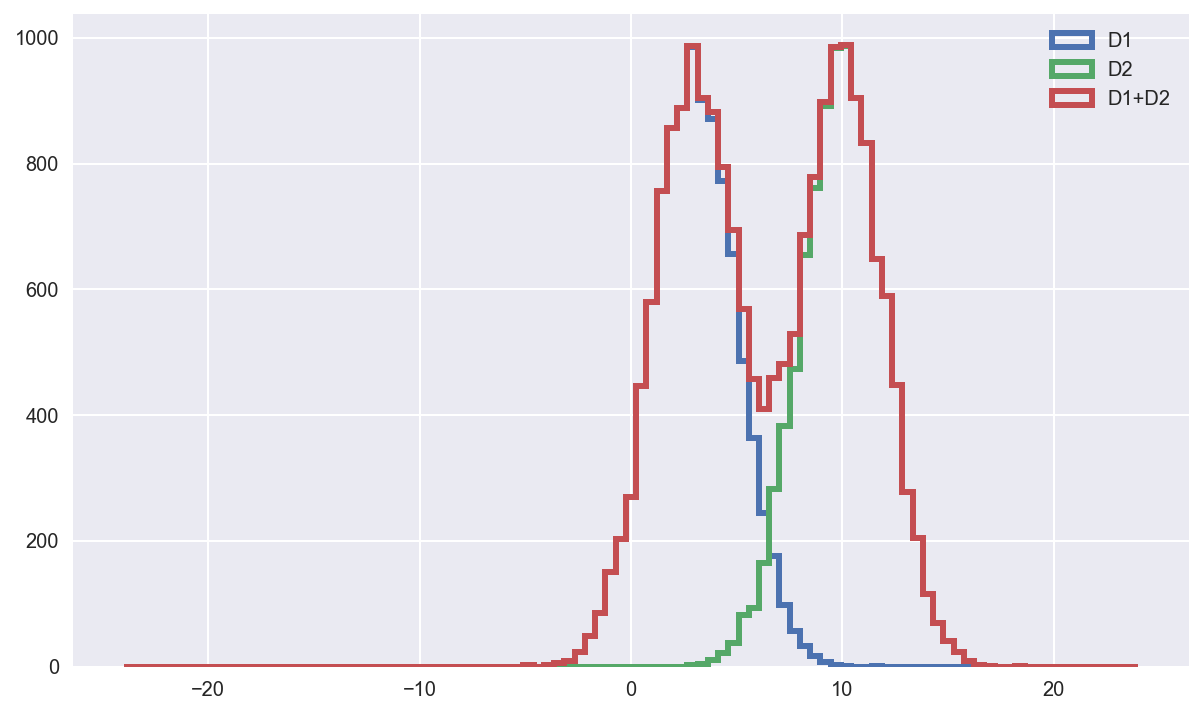

In [5]:
bins = np.linspace(-24,24, 100)
plt.hist(D1, bins=bins, histtype='step', lw=3, label='D1')
plt.hist(D2, bins=bins, histtype='step', lw=3, label='D2')

plt.hist(np.append(D1,D2), bins=bins, histtype='step', lw=3, label='D1+D2')
plt.legend()

(20000,)


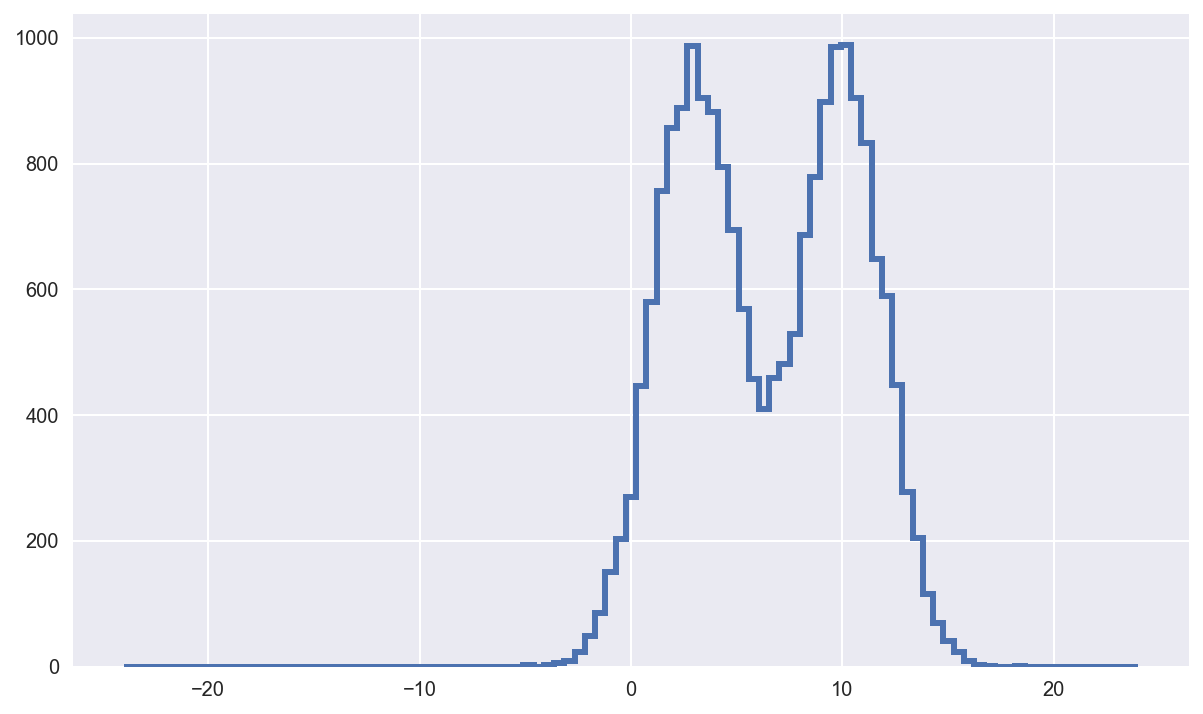

In [6]:
D = np.append(D1,D2)
print(D.shape)
plt.hist(D, bins=bins, histtype='step', lw=3, label='D1+D2');


In [7]:
D, D.shape

(array([ 3.8325813 ,  4.5118787 ,  1.5672114 , ...,  9.7165276 ,
         8.42221438, 10.31526487]), (20000,))

In [8]:
SEED = 20161210
with mc3.Model() as model:
    w = mc3.Dirichlet('w', np.ones_like(locs))

    mu = mc3.Uniform('mu', -10., 20., shape=locs.size)
    sd = mc3.Gamma('sd', 1., 1., shape=locs.size)

    x_obs = mc3.NormalMixture('x_obs', w, mu, sd=sd, observed=D)
    start = mc3.find_MAP()
    trace = mc3.sample(5000, n_init=10000, tune=1000, random_seed=SEED, start=start)[1000:]
    
    
    

logp = -56,258, ||grad|| = 20.23: 100%|██████████| 15/15 [00:00<00:00, 287.98it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, mu_interval__, w_stickbreaking__]
100%|██████████| 6000/6000 [01:49<00:00, 54.77it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w__0,0.502095,0.005886,0.000358,0.490300,0.513206,4.843649,1.326047
w__1,0.497905,0.005886,0.000358,0.486794,0.509700,4.843649,1.326047
mu__0,4.785595,3.032311,0.303217,2.979979,10.071518,2.000396,119.232852
mu__1,8.287095,3.032790,0.303265,2.999946,10.093111,2.000394,120.231022
sd__0,2.002793,0.030023,0.002084,1.941189,2.056740,3.768761,1.486459
sd__1,1.978679,0.029950,0.002090,1.926078,2.040642,3.732775,1.494551


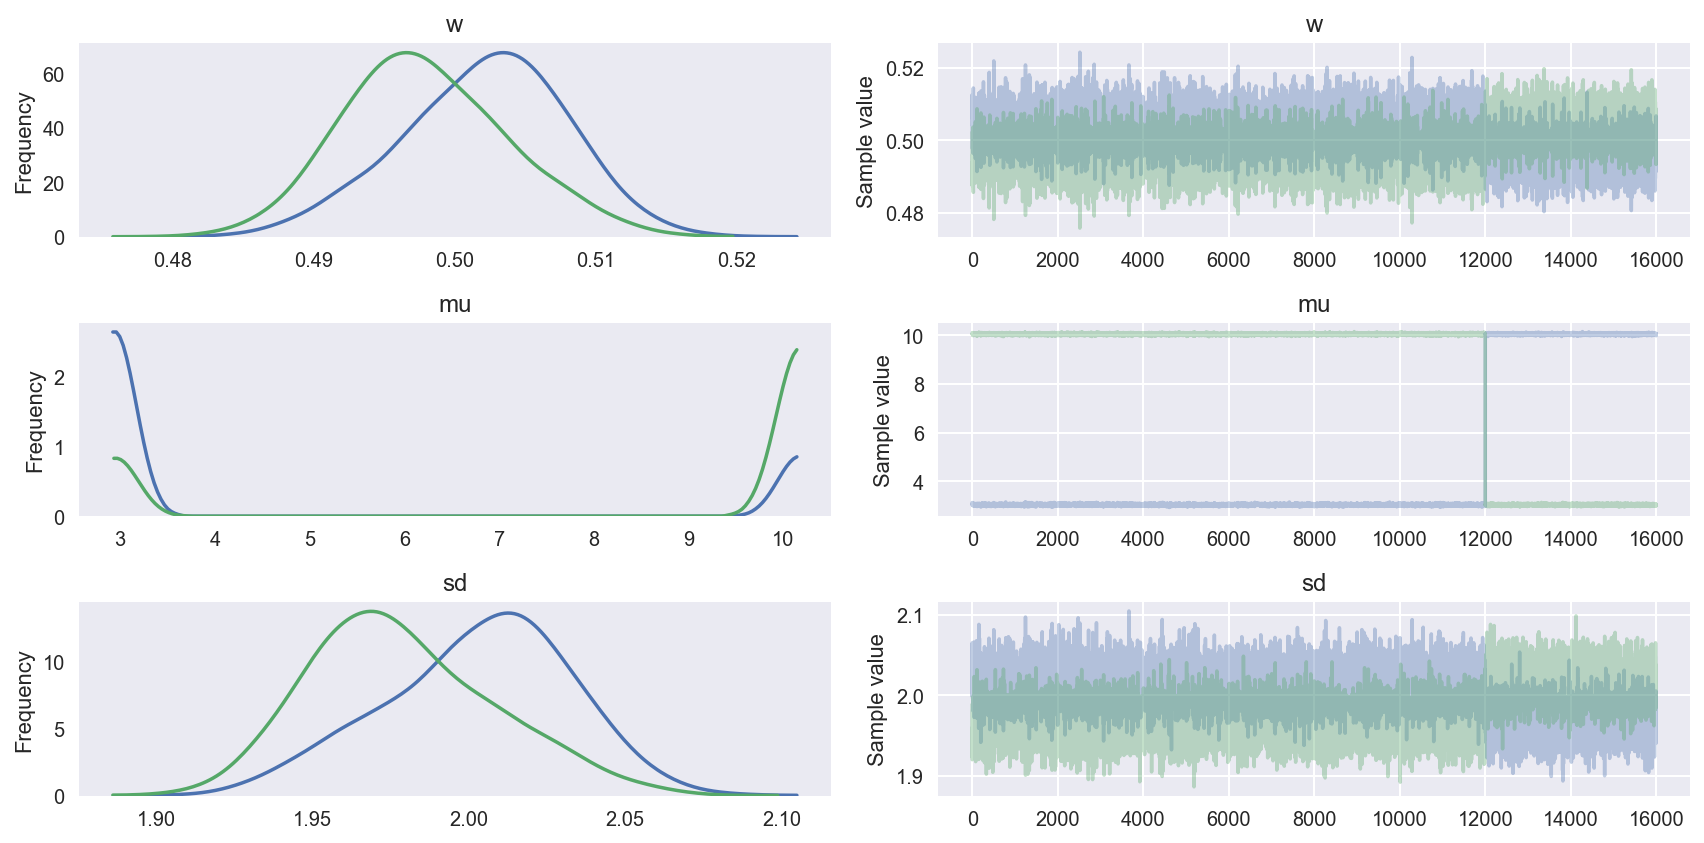

In [9]:
mc3.traceplot(trace, combined=True);
mc3.summary(trace)

100%|██████████| 500/500 [00:03<00:00, 153.02it/s]


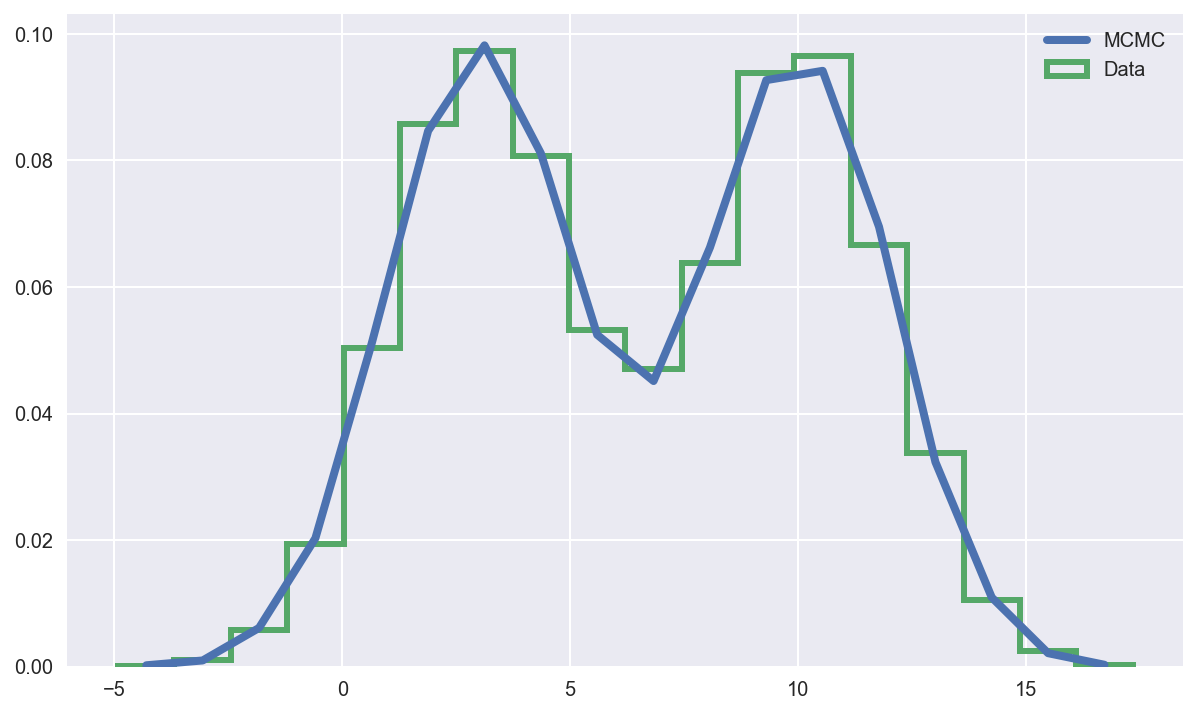

In [10]:
ppc = mc3.sample_ppc(trace, samples=500, model=model, size=100)
hist, bins = np.histogram(ppc['x_obs'], bins='doane', normed=True)
plt.plot(tb.bin_edges_to_center(bins), hist, lw=4, label='MCMC')
plt.hist(D, bins=bins, histtype='step', lw=3, normed=True, label='Data');
plt.legend()

In [11]:
with mc3.Model() as model:
    w = mc3.Dirichlet('w', np.ones_like(locs))

    mu1 = mc3.Uniform('mu1', -10., 20.)
    mu2 = mc3.Uniform('mu2', mu1, 20.)
    sd = mc3.Gamma('sd', 1., 1., shape=locs.size)

    x_obs = mc3.NormalMixture('x_obs', w, [mu1, mu2], sd=sd, observed=D)
    start = mc3.find_MAP()
    trace = mc3.sample(5000, n_init=10000, tune=1000, random_seed=SEED, start=start)[1000:]
    
    
    

logp = -53,982, ||grad|| = 114.99: 100%|██████████| 19/19 [00:00<00:00, 310.07it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, mu2_interval__, mu1_interval__, w_stickbreaking__]
100%|██████████| 6000/6000 [02:02<00:00, 49.04it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w__0,0.504091,0.004694,0.000050,0.495060,0.513333,9606.382574,1.000165
w__1,0.495909,0.004694,0.000050,0.486667,0.504940,9606.382574,1.000165
mu1,3.035239,0.029789,0.000307,2.978511,3.094166,9201.544003,1.000076
mu2,10.038342,0.029548,0.000279,9.982541,10.098003,8872.682432,0.999948
sd__0,2.014860,0.022179,0.000249,1.972698,2.059763,8224.641027,0.999958
sd__1,1.966632,0.021645,0.000225,1.923489,2.008421,9071.944201,0.999949


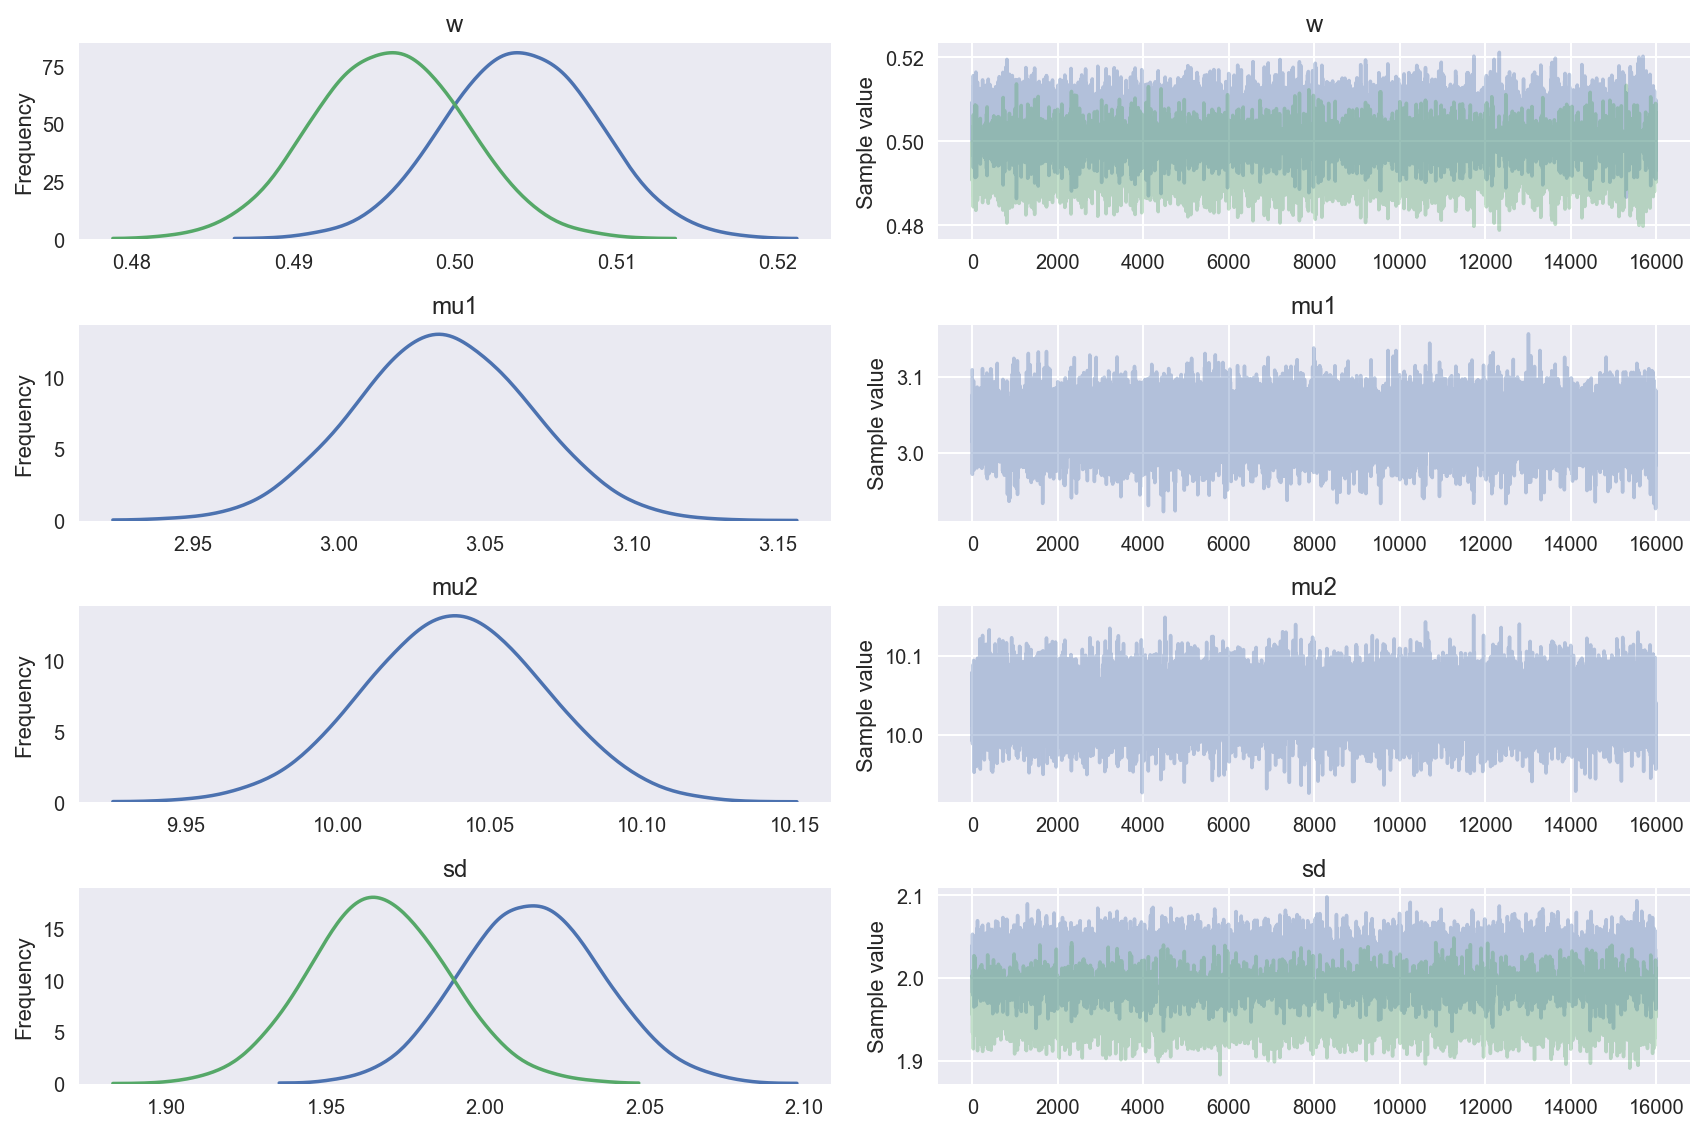

In [12]:
mc3.traceplot(trace, combined=True);
mc3.summary(trace)

100%|██████████| 500/500 [00:03<00:00, 151.13it/s]


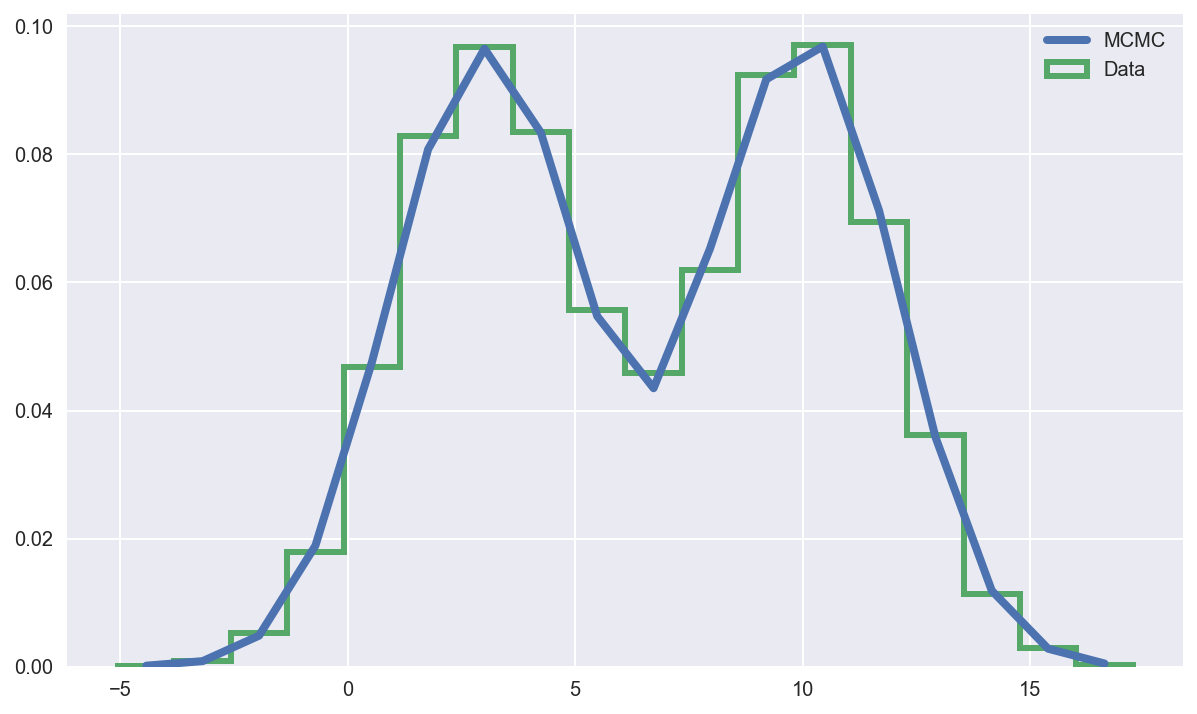

In [13]:
ppc = mc3.sample_ppc(trace, samples=500, model=model, size=100)
hist, bins = np.histogram(ppc['x_obs'], bins='doane', normed=True)
plt.plot(tb.bin_edges_to_center(bins), hist, lw=4, label='MCMC')
plt.hist(D, bins=bins, histtype='step', lw=3, normed=True, label='Data');
plt.legend()